In [1]:
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model_name = "codesage/codesage-small" #"BAAI/bge-small-en"
model_kwargs = {"device": "cpu", "trust_remote_code":True}
encode_kwargs = {"normalize_embeddings": True}
bge_embed = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

No sentence-transformers model found with name codesage/codesage-small. Creating a new one with MEAN pooling.


In [2]:
df = pd.read_csv('train.csv')
df.head()
len(df)

108971

In [ ]:
texts = df['text'].to_numpy()

In [ ]:
texts = np.random.choice(texts, 10000, replace=False)
embeddings = np.array([bge_embed.embed_query(text) for text in texts])
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)
# Plot


In [ ]:
np.savez('sample_verilog_10000_code_sage_small.npz', texts=texts, code_sage_small=embeddings, tsne=tsne_results)

In [ ]:
fig = plt.subplots(figsize=(12, 12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## PCA 
We look at how many components we need to explain the variance in data

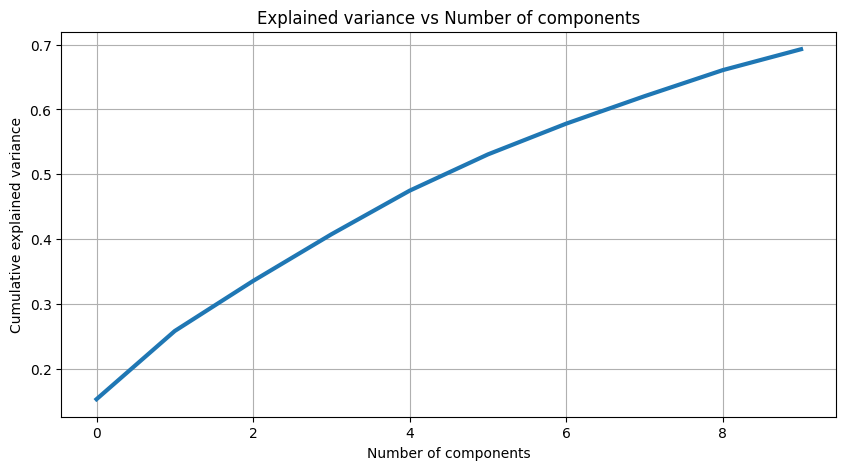

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

with np.load('sample_verilog_ast_cleaned_10000_code_sage_small.npz', allow_pickle=True) as data:
    embeddings = data['code_sage_small'] # data['bge_embeddings'] 
    texts = data['texts']

# Running PCA from 1 to n components
pca = PCA(n_components=embeddings.shape[1])
pca.fit(embeddings)

# The amount of variance that each PC explains
variance = pca.explained_variance_ratio_

# The cumulative variance explained by the PCs
cumulative_variance = np.cumsum(variance)

# Plotting the cumulative variance against the number of components
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance[:10], lw=3)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs Number of components')
plt.grid(True)
plt.show()


# Kmeans Cluster

c:\Users\arash\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


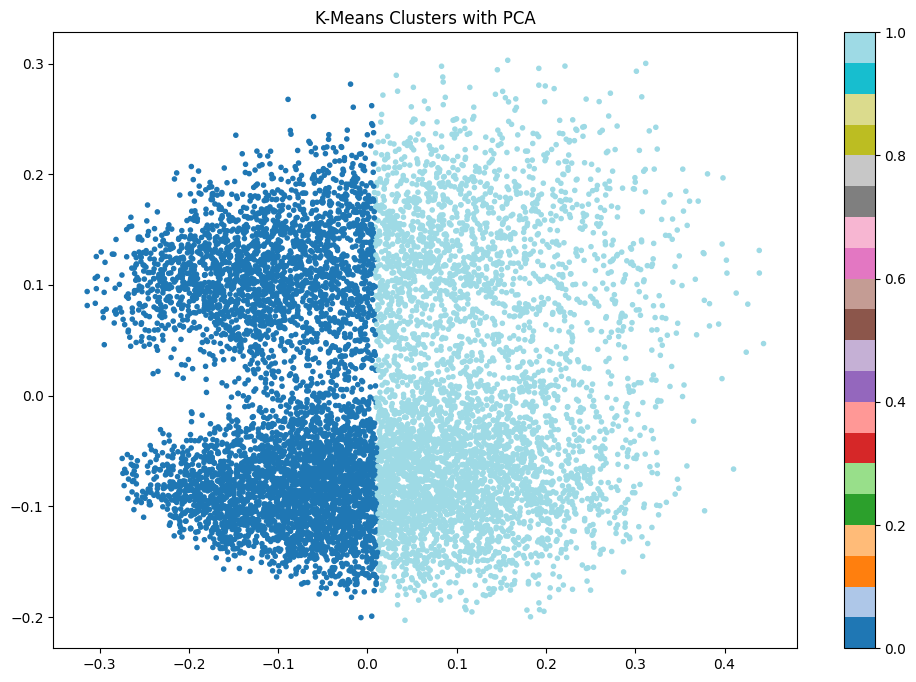

In [53]:
kmeans = KMeans(n_clusters=2, random_state=52)  # You can choose a number of clusters suited for your dataset

# Reduce dimensions to 2D using t-SNE for visualization purposes
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
kmeans.fit(embeddings_pca)
labels = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='tab20', marker='.')
plt.title('K-Means Clusters with PCA')
plt.colorbar()
plt.show()

# Gaussian cluster

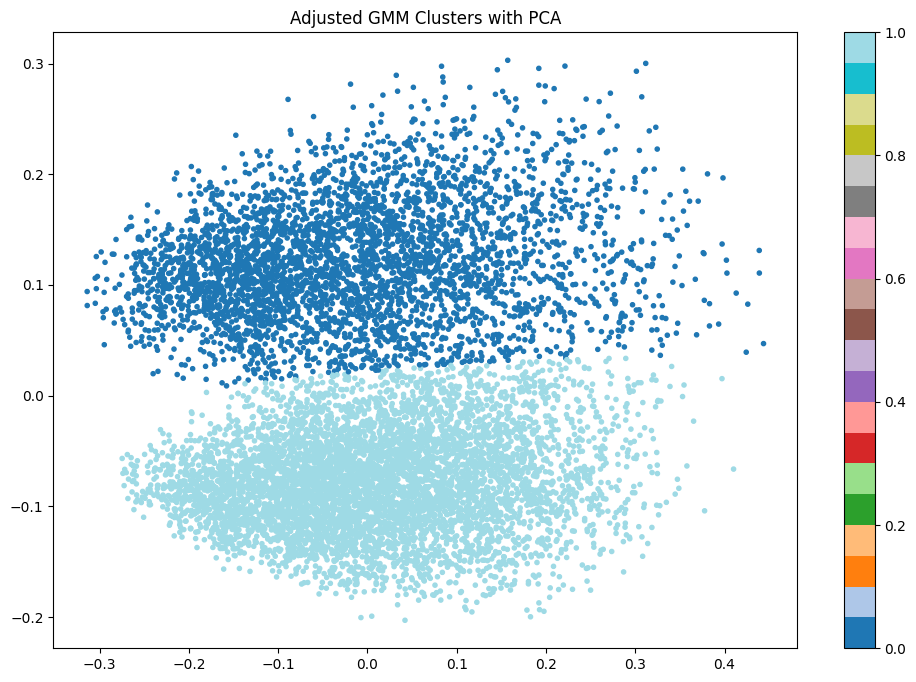

In [54]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Fit GMM with 2 components, adjusting covariance type and initialization
gmm = GaussianMixture(n_components=2, covariance_type='full', n_init=10, init_params='kmeans', random_state=52)
gmm.fit(embeddings_pca)
labels = gmm.predict(embeddings_pca)

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='tab20', marker='.')
plt.title('Adjusted GMM Clusters with PCA')
plt.colorbar()
plt.show()


In [58]:
texts[np.where(labels == 0)]

array(['\n(* var_193 = "yes" *)\n\n\nmodule var_194 #\n(\n  parameter var_195 = 8,\n  parameter var_196 = 4,\n  parameter var_197 = 16\n)\n(\n  input wire var_198,\n  input wire var_199,\n  input wire var_200,\n  input wire var_201,\n  input wire [var_203-1:0] var_202,\n  output wire [var_203-1:0] var_204,\n  output wire var_205,\n  output wire var_206,\n  output wire var_207,\n  output wire var_208\n);\n\n  localparam [var_196-1:0] var_209 = ~0;\n  localparam [var_196-1:0] var_210 = 0;\n  localparam [var_196-1:0] var_211 = var_209 - 1;\n  localparam [var_196-1:0] var_212 = (var_197 < 8)? var_211 - 1 : var_211 - var_197 / 8;\n  reg [var_195-1:0] var_213 [var_197-1:0];\n  reg [var_196-1:0] var_214;\n\n  always @(posedge var_198) begin : BLKSRL\n    integer var_215;\n    if(var_200) begin\n      for(var_215=0; var_215<var_197-1; var_215=var_215+1) begin\n        var_213[var_215 + 1] <= var_213[var_215];\n      end\n      var_213[0] <= var_202;\n    end \n  end\n\n\n  always @(posedge var

In [57]:
texts[np.where(labels == 1)]

array(['\n(* var_1009 = "yes" *)\n\n\nmodule var_1010 #\n(\n  parameter var_1011 = 8,\n  parameter var_1012 = 4,\n  parameter var_1013 = 16\n)\n(\n  input wire var_1014,\n  input wire var_1015,\n  input wire var_1016,\n  input wire var_1017,\n  input wire [var_1019-1:0] var_1018,\n  output wire [var_1019-1:0] var_1020,\n  output wire var_1021,\n  output wire var_1022,\n  output wire var_1023,\n  output wire var_1024\n);\n\n  localparam [var_1012-1:0] var_1025 = ~0;\n  localparam [var_1012-1:0] var_1026 = 0;\n  localparam [var_1012-1:0] var_1027 = var_1025 - 1;\n  localparam [var_1012-1:0] var_1028 = (var_1013 < 8)? var_1027 - 1 : var_1027 - var_1013 / 8;\n  reg [var_1011-1:0] var_1029 [var_1013-1:0];\n  reg [var_1012-1:0] var_1030;\n\n  always @(posedge var_1014) begin : BLKSRL\n    integer var_1031;\n    if(var_1016) begin\n      for(var_1031=0; var_1031<var_1013-1; var_1031=var_1031+1) begin\n        var_1029[var_1031 + 1] <= var_1029[var_1031];\n      end\n      var_1029[0] <= var_1

In [35]:
data.files

['texts', 'bge_embeddings', 'tsne']

There is no elbow in the data which suggests that we should probably keep everything and we should not reduce the number of components before performing any clustering.

## Clustering

We attempt to perform (unsupervised) clustering of our datapoints. We further dig into the clusters to see what we find.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'embeddings' is your dataset
embeddings_normalized = normalize(embeddings)

# Range of number of clusters
n_clusters = range(2, 61)  # Silhouette score cannot be computed with only one cluster

silhouette_scores = []

for k in n_clusters:
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_normalized)
    
    # Compute the silhouette score and append it to the list
    score = silhouette_score(embeddings_normalized, cluster_labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score}")

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'embeddings' is your dataset with text data represented in high-dimensional space

# Normalize the embeddings to unit length, which makes the KMeans clustering similar to using cosine similarity
embeddings_normalized = normalize(embeddings)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=12, random_state=42)  # You can choose a number of clusters suited for your dataset
kmeans.fit(embeddings_normalized)
labels = kmeans.labels_

# Reduce dimensions to 2D using t-SNE for visualization purposes
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_normalized)

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='tab20', marker='.')
plt.title('K-Means Clusters with t-SNE')
plt.colorbar()
plt.show()

In [ ]:
np.where(labels == 7)

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_openai import ChatOpenAI

chat = ChatOpenAI(temperature=0, model='gpt-3.5-turbo-0125')

template = (
    "You are a hardware engineer that describes verilog code written by other engineers. Your response should be concise. it should br one or two sentences maximum."
)
system_message_prompt = SystemMessagePromptTemplate.from_template(template)
human_template = "{text}"
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

chat_prompt = ChatPromptTemplate.from_messages(
    [system_message_prompt, human_message_prompt]
)

# get a chat completion from the formatted messages
chat.invoke(
    chat_prompt.format_prompt(
        text=texts[0]
    ).to_messages()
)

In [9]:
verilog_code = df.loc[15]['text']
verilog_code

'`include "hi_simulate.v"\n\n/*\n\tpck0\t\t\t- input main 24Mhz clock (PLL / 4)\n\t[7:0] adc_d\t\t- input data from A/D converter\n\tmod_type\t- modulation type\n\n\tpwr_lo\t\t\t- output to coil drivers (ssp_clk / 8)\n\tadc_clk\t\t\t- output A/D clock signal\n\tssp_frame\t\t- output SSS frame indicator (goes high while the 8 bits are shifted)\n\tssp_din\t\t\t- output SSP data to ARM (shifts 8 bit A/D value serially to ARM MSB first)\n\tssp_clk\t\t\t- output SSP clock signal\n\n\tck_1356meg\t\t- input unused\n\tck_1356megb\t\t- input unused\n\tssp_dout\t\t- input unused\n\tcross_hi\t\t- input unused\n\tcross_lo\t\t- input unused\n\n\tpwr_hi\t\t\t- output unused, tied low\n\tpwr_oe1\t\t\t- output unused, undefined\n\tpwr_oe2\t\t\t- output unused, undefined\n\tpwr_oe3\t\t\t- output unused, undefined\n\tpwr_oe4\t\t\t- output unused, undefined\n\tdbg\t\t\t\t- output alias for adc_clk\n*/\n\nmodule testbed_hi_simulate;\n\treg  pck0;\n\treg  [7:0] adc_d;\n\treg  mod_type;\n\n\twire pwr_lo;\n\

In [14]:
import pyverilog
import pyverilog.vparser.parser as vp

# Example Verilog code as a string
verilog_code = df.loc[100]['text']

# Parse the Verilog code
ast, directives = vp.parse([verilog_code])

# Now `ast` contains the Abstract Syntax Tree of the Verilog code
ast.show()


Generating LALR tables


Source:  (at 9)
  Description:  (at 9)
    Pragma:  (at 9)
      PragmaEntry: DowngradeIPIdentifiedWarnings (at 9)
        StringConst: yes (at 9)
    ModuleDef: axi_protocol_converter_v2_1_b2s_wr_cmd_fsm (at 10)
      Paramlist:  (at 0)
      Portlist:  (at 10)
        Ioport:  (at 14)
          Input: clk, False (at 14)
          Wire: clk, False (at 14)
        Ioport:  (at 15)
          Input: reset, False (at 15)
          Wire: reset, False (at 15)
        Ioport:  (at 16)
          Output: s_awready, False (at 16)
          Wire: s_awready, False (at 16)
        Ioport:  (at 17)
          Input: s_awvalid, False (at 17)
          Wire: s_awvalid, False (at 17)
        Ioport:  (at 18)
          Output: m_awvalid, False (at 18)
          Wire: m_awvalid, False (at 18)
        Ioport:  (at 19)
          Input: m_awready, False (at 19)
          Wire: m_awready, False (at 19)
        Ioport:  (at 21)
          Output: next, False (at 21)
          Wire: next, False (at 21)
        

In [14]:
def anonymize_variable_names(node, anonymized_names=None, next_id=[0]):
    if anonymized_names is None:
        anonymized_names = {}

    # Check if the node is of a type that contains a variable name
    if isinstance(node, pyverilog.vparser.ast.Identifier) or hasattr(node, 'name'):
        original_name = node.name
        if original_name not in anonymized_names:
            anonymized_name = f"var_{next_id[0]}"
            anonymized_names[original_name] = anonymized_name
            next_id[0] += 1
        node.name = anonymized_names[original_name]

    # Recursively process child nodes
    for child in node.children():
        anonymize_variable_names(child, anonymized_names, next_id)

# Example of using the function
# Assume `ast` is the root node of your AST
anonymize_variable_names(ast)


In [15]:
ast.show()

Source: var_0 (at 8)
  Description:  (at 8)
    Pragma:  (at 8)
      PragmaEntry: var_1 (at 8)
        StringConst: yes (at 8)
    ModuleDef: var_2 (at 9)
      Paramlist:  (at 9)
        Decl:  (at 11)
          Parameter: var_3, False (at 11)
            Rvalue:  (at 11)
              IntConst: 8 (at 11)
        Decl:  (at 12)
          Parameter: var_4, False (at 12)
            Rvalue:  (at 12)
              IntConst: 4 (at 12)
        Decl:  (at 13)
          Parameter: var_5, False (at 13)
            Rvalue:  (at 13)
              IntConst: 16 (at 13)
      Portlist:  (at 15)
        Ioport:  (at 16)
          Input: var_6, False (at 16)
          Wire: var_6, False (at 16)
        Ioport:  (at 17)
          Input: var_7, False (at 17)
          Wire: var_7, False (at 17)
        Ioport:  (at 18)
          Input: var_8, False (at 18)
          Wire: var_8, False (at 18)
        Ioport:  (at 19)
          Input: var_9, False (at 19)
          Wire: var_9, False (at 19)
        I

In [16]:
# making networkx graph out 
import networkx as nx
from matplotlib import pyplot as plt

G = nx.DiGraph()

def build_graph(node, graph, parent=None, labels={}, node_id=[0]):
    """
    Recursively traverse the Pyverilog AST and build a corresponding networkx graph.

    :param node: Current AST node being processed
    :param graph: networkx graph being built
    :param parent: Parent node's ID in the networkx graph
    :param labels: Dictionary for node labels
    :param node_id: List with a single element acting as a mutable counter for node IDs
    """
    # Assign an ID to the current node and increment the global node counter
    current_id = node_id[0]
    node_id[0] += 1
    
    # Create a label for the current node based on its class name; you might want to include more details
    try:
        labels[current_id] = f"{node.name}\n({node.lineno})"
    except:
        labels[current_id] = f"{node.__class__.__name__}\n({node.lineno})"
    
    # Add the current node to the graph
    graph.add_node(current_id)
    
    # If this node has a parent, add an edge from the parent to this node
    if parent is not None:
        graph.add_edge(parent, current_id)
    
    # Recursively process each child node
    for child in node.children():
        if child is not None:  # Ensure the child exists
            build_graph(child, graph, current_id, labels, node_id)

# Example usage of the function
labels = {}
build_graph(ast, G, labels=labels)



C:\Users\arash\AppData\Local\Temp\ipykernel_37220\1468858983.py:5: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='dot')


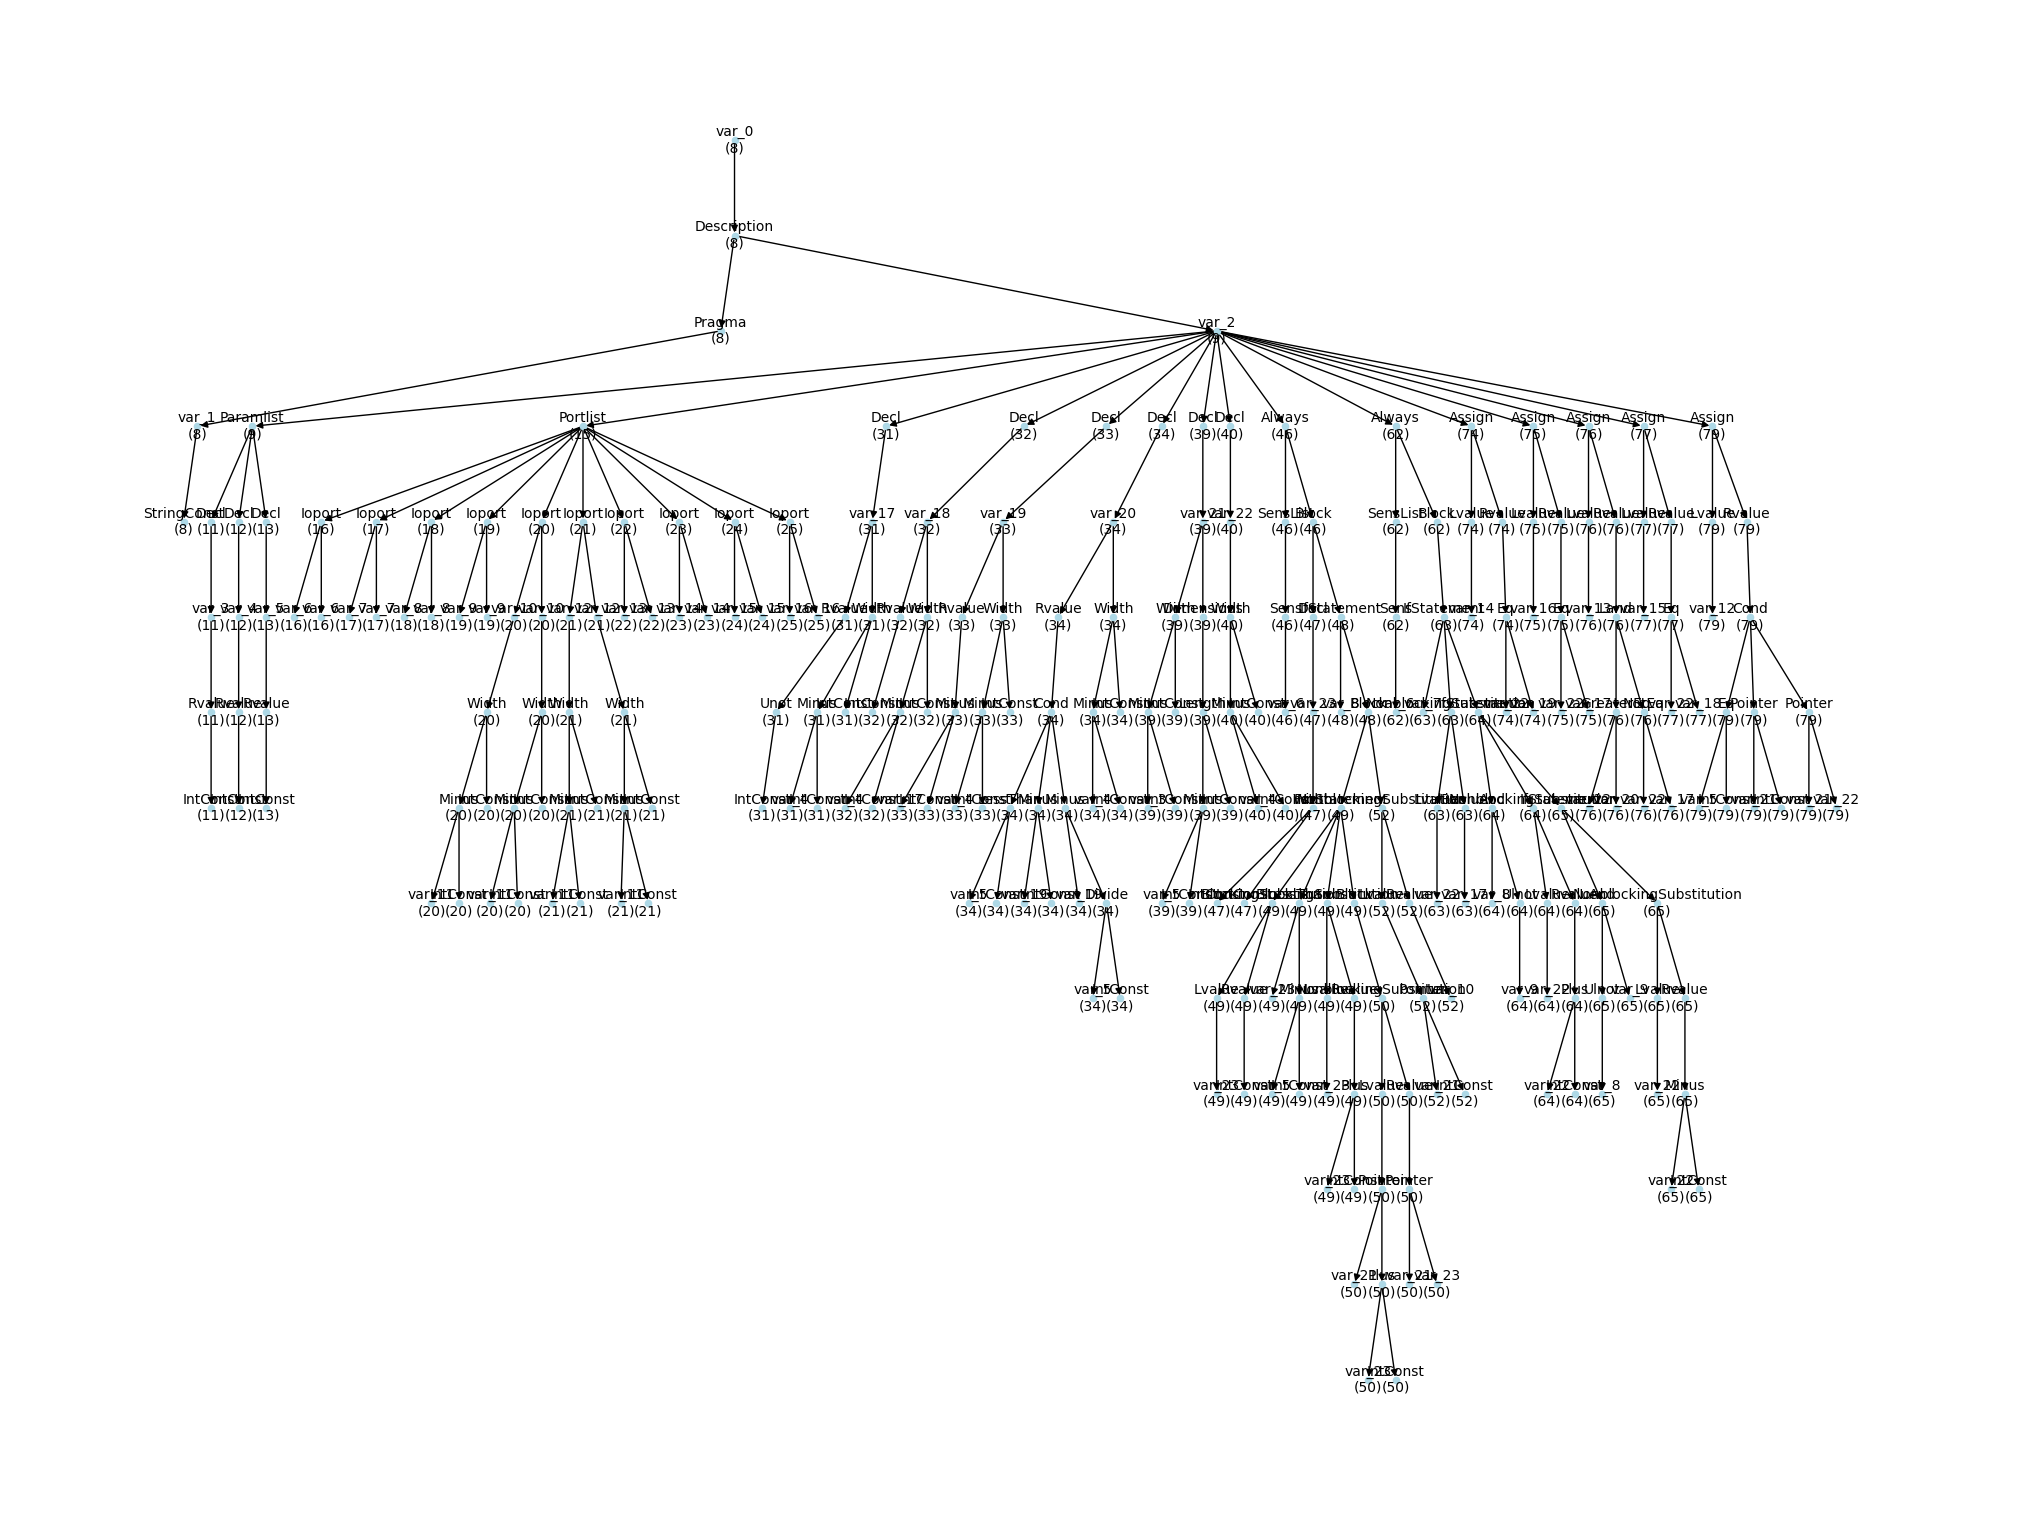

In [17]:
plt.figure(figsize=(20, 15))  # Width, height in inches

# Draw the graph
#pos = nx.spring_layout(G)  # Generate a layout for the graph's nodes
pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw(G, pos, labels=labels, with_labels=True, node_size=20, node_color="lightblue", font_size=10)
plt.show()

In [18]:
from pyverilog.ast_code_generator.codegen import ASTCodeGenerator

# Generate Verilog code from the AST
codegen = ASTCodeGenerator()
verilog_code_from_ast = codegen.visit(ast)

# Print the generated Verilog code
print(verilog_code_from_ast)




(* var_1 = "yes" *)


module var_2 #
(
  parameter var_3 = 8,
  parameter var_4 = 4,
  parameter var_5 = 16
)
(
  input wire var_6,
  input wire var_7,
  input wire var_8,
  input wire var_9,
  input wire [var_11-1:0] var_10,
  output wire [var_11-1:0] var_12,
  output wire var_13,
  output wire var_14,
  output wire var_15,
  output wire var_16
);

  localparam [var_4-1:0] var_17 = ~0;
  localparam [var_4-1:0] var_18 = 0;
  localparam [var_4-1:0] var_19 = var_17 - 1;
  localparam [var_4-1:0] var_20 = (var_5 < 8)? var_19 - 1 : var_19 - var_5 / 8;
  reg [var_3-1:0] var_21 [var_5-1:0];
  reg [var_4-1:0] var_22;

  always @(posedge var_6) begin : BLKSRL
    integer var_23;
    if(var_8) begin
      for(var_23=0; var_23<var_5-1; var_23=var_23+1) begin
        var_21[var_23 + 1] <= var_21[var_23];
      end
      var_21[0] <= var_10;
    end 
  end


  always @(posedge var_6) begin
    if(var_7) var_22 <= var_17; 
    else if(var_8 & !var_9) var_22 <= var_22 + 1'b1; 
    else if(!var_8 & v

In [22]:
# create code form AST
from tqdm.notebook import tqdm
texts = np.random.choice(texts, 10000, replace=False)

for i in tqdm(range(len(texts))):
    verilog_code = df.loc[0]['text']

    # Parse the Verilog code
    ast, directives = vp.parse([verilog_code])
    anonymize_variable_names(ast)
    texts[i] = codegen.visit(ast)
embeddings = np.array([bge_embed.embed_query(text) for text in texts])
np.savez('sample_verilog_ast_cleaned_10000_code_sage_small.npz', texts=texts, code_sage_small=embeddings)

  0%|          | 0/10000 [00:00<?, ?it/s]

Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating 